In [1]:
# Imports

import random
import multiprocessing as mp

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import shap

import lime
import lime.lime_tabular

from utils import get_data, get_model

shap.initjs()

In [2]:
# %pip install shap lime

In [3]:
# df = pd.read_csv('brain_stroke.csv')

In [4]:
# df.head()

In [5]:
X_train, y_train, X_test, y_test = get_data('all')

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [7]:
# df.stroke.sum() / len(df)

In [8]:
def eval_model(y_test, X_test, model):
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Accuracy
    accuracy = sk_metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = sk_metrics.confusion_matrix(y_test, y_pred)

    # Plotting the smaller confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # F1 Score
    f1 = sk_metrics.f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

    # Recall
    rec = sk_metrics.recall_score(y_test, y_pred)
    print(f"Recall: {rec:.4f}")

    # ROC AUC Score
    roc_auc = sk_metrics.roc_auc_score(y_test, y_pred)
    print(f"ROC AUC Score: {roc_auc:.4f}")

    return accuracy, f1, roc_auc

# Example usage:
# eval_model(y_test, X_test, your_model)


# train model

### Random Forest

In [9]:
model = keras.models.load_model('model/')

4501/4501 [==============================] - 3s 559us/step
Accuracy: 0.7518


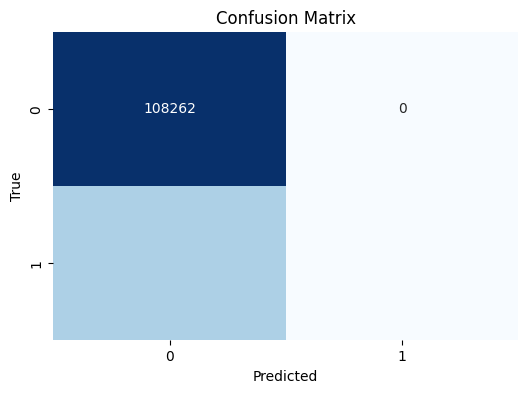

F1 Score: 0.0000
Recall: 0.0000
ROC AUC Score: 0.5000


(0.7518142235123367, 0.0, 0.5)

In [10]:
eval_model(y_test, X_test, model)

In [19]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=[0, 1],
    mode='classification'
)

In [14]:
print(f"Anzahl aller Instanzen: "+str(len(X_test)))

Anzahl aller Instanzen: 144001


In [25]:
import numpy as np

# def predict_proba(x):
#     probs = model.predict(x)
#     return probs / np.sum(probs, axis=-1, keepdims=True)

def predict_proba(x):
    # Get the probability of the positive class
    positive_proba = model.predict(x)

    # Calculate the probability of the negative class
    negative_proba = 1 - positive_proba

    # Concatenate the probabilities and return
    return np.concatenate([negative_proba, positive_proba], axis=-1)

In [26]:
i = 993  # Instanz welche näher angeschaut wird (hier zwischen 0-996)
x = X_test.values[i]

explanation = explainer.explain_instance(x, predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True)

# Note:
# Gender 1 = Female


157/157 [==============================] - 0s 542us/step


In [28]:
from collections import defaultdict
def calc_global_explanations(explanations):
    # Assuming 'all_explanations' is a list of lists of tuples (like your local values)
    word_scores = defaultdict(list)
    # word_scores = {}
    for explanation in explanations:
        # print(explanation)
        for word, score in explanation:
            word_scores[word].append(score)

    # Calculate the average
    average_scores = {word: sum(scores)/len(scores) for word, scores in word_scores.items()}

    # Remove words with an average score of 0.000 when rounded to 3 decimal places
    average_scores = {key: value for key, value in average_scores.items() if round(value,3) != 0}
    
    average_scores = sorted(average_scores.items(), key=lambda x: x[1])
    print(average_scores)

    return [key for key, value in average_scores], [value for key, value in average_scores]

In [ ]:
healthy = []
non_healthy=[]
for i in range(len(X_test.iloc[:30])):
    exp = explainer.explain_instance(X_test.iloc[i], predict_proba, num_features=6)
    # print('Probability(suicide) =', make_proba_predictions([X_test.iloc[idx]])[0,1])
    if y_test.iloc[i] == 1:
        healthy.append(exp.as_list())
    else:
        non_healthy.append(exp.as_list())


avg_healthy_labels, avg_healthy_scores = calc_global_explanations(healthy)
avg_non_healthy_labels, avg_non_healthy_scores = calc_global_explanations(non_healthy)

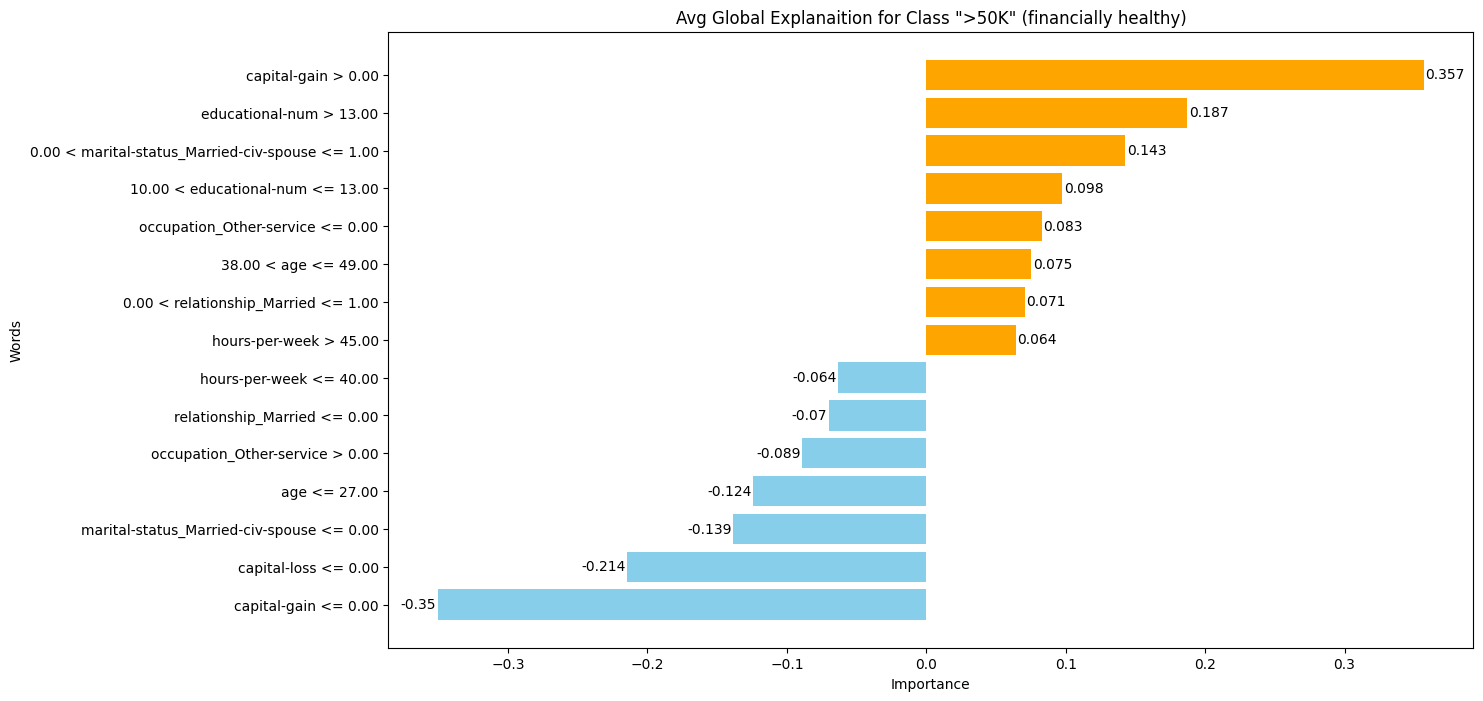

In [32]:
plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
colors = ['orange' if x >= 0 else 'skyblue' for x in avg_healthy_scores]
bars = plt.barh(avg_healthy_labels, avg_healthy_scores, color=colors, align='center')  # You can change the color

# Adding labels and title (optional)
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Avg Global Explanaition for Class ">50K" (financially healthy)')

for bar in bars:
    width = bar.get_width()
    label_x_pos = bar.get_width() + (0.001 if width > 0 else -0.001)  # Adjust label position
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{round(width,3)}', 
             va='center', ha='right' if width < 0 else 'left')

# Display the plot
plt.show()

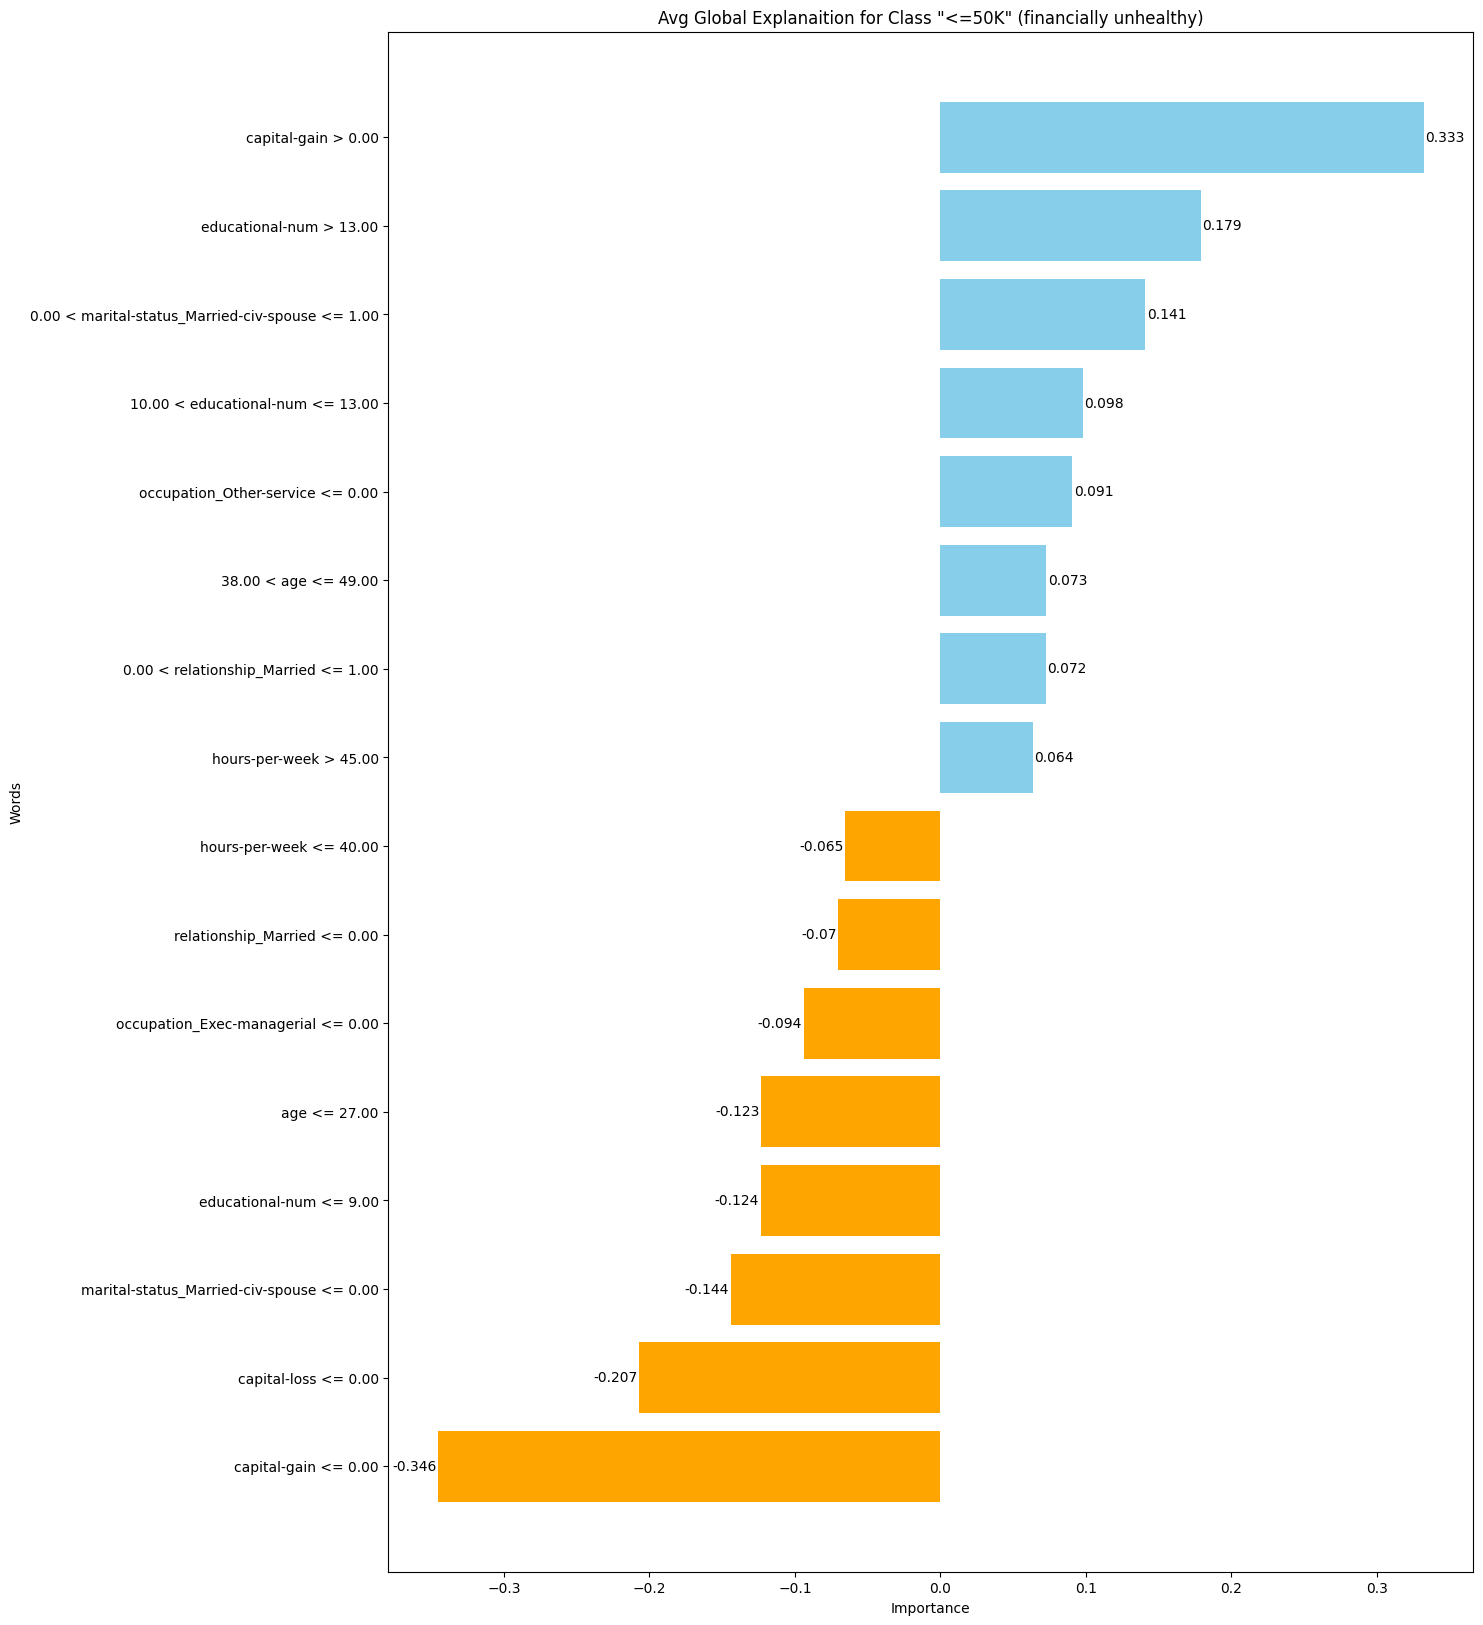

In [33]:
plt.figure(figsize=(14, 20))  # Adjust the figure size as needed
colors = ['skyblue' if x >= 0 else 'orange' for x in avg_non_healthy_scores]
bars = plt.barh(avg_non_healthy_labels, avg_non_healthy_scores, color=colors, align='center')  # You can change the color

# Adding labels and title (optional)
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Avg Global Explanaition for Class "<=50K" (financially unhealthy)')

for bar in bars:
    width = bar.get_width()
    label_x_pos = bar.get_width() + (0.001 if width > 0 else -0.001)  # Adjust label position
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{round(width,3)}', 
             va='center', ha='right' if width < 0 else 'left')

# Display the plot
plt.show()